# Evaluate Power of MIGHT and its variants on two-sample testing for S@S98

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from joblib import Parallel, delayed
from scipy.integrate import nquad, quad, simps
from scipy.stats import entropy, gamma, multivariate_normal, norm
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize
from sktree.datasets import make_trunk_classification
from sktree.ensemble import HonestForestClassifier
from sktree.stats import FeatureImportanceForestClassifier, build_coleman_forest
from sktree.tree import DecisionTreeClassifier

In [3]:
SIMULATIONS = {
    "1": {},
    "2": {"m_factor": 1},
    "3": {"band_type": "ar", "rho": 0.5},
    "4": {"band_type": "ar", "m_factor": 1, "rho": 0.5},
}

In [5]:
SAMP_SIZES = [2**i for i in range(8, 10)]
SAMP_SIZES_plot = [2 * 2**i for i in range(8, 10)]
DIM = 4**6
REPS = range(100, 1000)
P = 4096
SAVE_PATH = "/Volumes/Extreme Pro/cancer/output/power_exp"

## Using Correct Forests

In [6]:
SAMP_SIZES = [2**i for i in range(8, 12)]
print(SAMP_SIZES)

[256, 512, 1024, 2048]


In [10]:
seed = 12345
n_jobs = -1
# test_size = 0.2
n_estimators = 500

In [11]:
MODEL_NAMES = {
    # "might-honestfraction05-bootstrap-x5": {
    #     "n_estimators": n_estimators,
    #     "random_state": seed,
    #     "honest_fraction": 0.5,
    #     "n_jobs": n_jobs,
    #     "bootstrap": False,
    #     "stratify": True,
    # },
    # "might-honestfraction05-bootstrap-maxsamples127": {
    #     "n_estimators": n_estimators,
    #     "random_state": seed,
    #     "honest_fraction": 0.5,
    #     "n_jobs": n_jobs,
    #     "bootstrap": True,
    #     "stratify": True,
    #     "max_samples": 1.27,
    # },
    "might-honestfraction05-bootstrap-maxsamples16-permutepertree": {
        "n_estimators": n_estimators,
        "random_state": seed,
        "honest_fraction": 0.5,
        "n_jobs": n_jobs,
        "bootstrap": True,
        "stratify": True,
        "max_samples": 1.6,
        "permute_per_tree": True,
        "n_jobs": -1,
    },
    # "might-honestfraction05-bootstrap-maxsamples16": {
    #     "n_estimators": n_estimators,
    #     "random_state": seed,
    #     "honest_fraction": 0.5,
    #     "n_jobs": n_jobs,
    #     "bootstrap": True,
    #     "stratify": True,
    #     "max_samples": 1.6,
    # },
    # "might-honestfraction025-bootstrap": {
    #     "n_estimators": n_estimators,
    #     "random_state": seed,
    #     "honest_fraction": 0.25,
    #     "n_jobs": n_jobs,
    #     "bootstrap": True,
    #     "stratify": True,
    # },
    # "might-honestfraction075-bootstrap": {
    #     "n_estimators": n_estimators,
    #     "random_state": seed,
    #     "honest_fraction": 0.75,
    #     "n_jobs": n_jobs,
    #     "bootstrap": True,
    #     "stratify": True,
    # },
    # "might-honestfraction05-honestbootstrap": {
    #     "n_estimators": n_estimators,
    #     "random_state": seed,
    #     "honest_fraction": 0.5,
    #     "n_jobs": n_jobs,
    #     "bootstrap": True,
    #     "stratify": True,
    #     "honest_bootstrap": True,
    # },
}

In [12]:
est = HonestForestClassifier(
    **MODEL_NAMES["might-honestfraction05-bootstrap-maxsamples16-permutepertree"]
)
n_repeats = 200

In [ ]:
n_dims = 4096
overwrite = False

for i in ["2"]:
    for rep in range(n_repeats):
        for n_samples in SAMP_SIZES:
            output_fpath = "{}/{}_{}_{}_{}.txt".format(
                SAVE_PATH, i, "MIGHT_Coleman_pertree", n_samples, rep
            )
            if os.path.exists(output_fpath) and not overwrite:
                continue
            X, y, mu, cov = make_trunk_classification(
                n_samples=n_samples,
                n_dim=n_dims,
                **SIMULATIONS[i],
                return_params=True,
            )
            X = np.float32(X)
            y = np.float32(y)
            if y.ndim == 1:
                y = y[:, np.newaxis]

            (
                observe_test_stat,
                pvalue,
                orig_forest_proba,
                perm_forest_proba,
            ) = build_coleman_forest(
                est,
                X,
                y,
                covariate_index=None,
                metric="sas98",
                n_repeats=1000,
                seed=seed,
                return_posteriors=True,
                # **metric_kwargs,
            )
            print(pvalue)
            np.savetxt(
                output_fpath,
                [observe_test_stat, pvalue],
                delimiter=",",
            )

/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.2777222777222777


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.7042957042957043


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


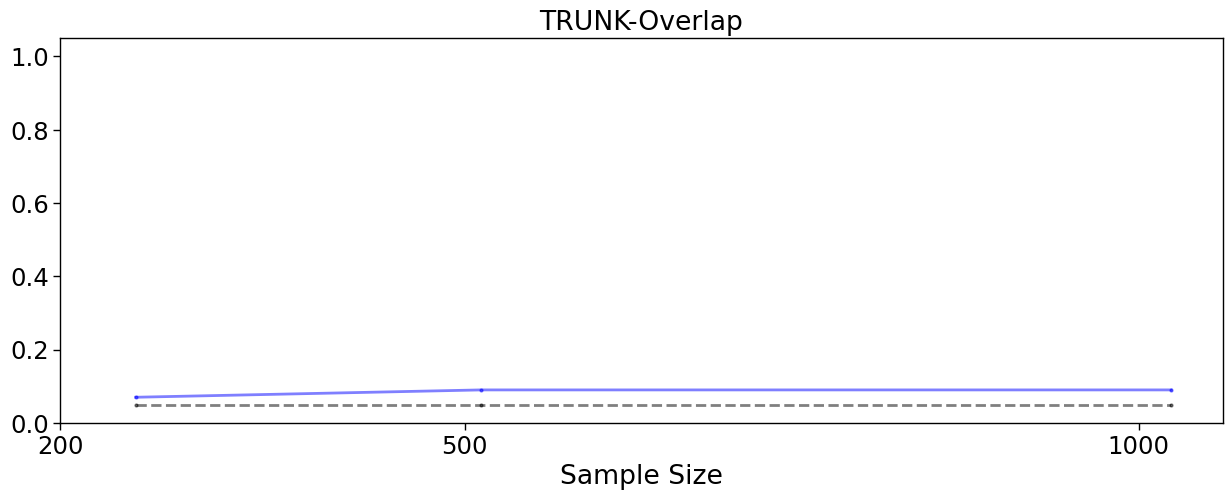

In [53]:
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(28, 14))

SAMP_SIZES = [2**i for i in range(8, 11)]
SAMP_SIZES_plot = [2 * 2**i for i in range(7, 10)]


plt.rcParams["font.size"] = 10
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
REPs = 20
ALPHA = 0.05
for sim in ["2"]:
    power_MIGHT = []
    for n in SAMP_SIZES:
        pvals = []
        for idx in range(100):
            file_name = "{}/{}_{}_{}_{}.txt".format(
                SAVE_PATH, sim, "MIGHT_Coleman", n, idx
            )
            pval = np.loadtxt(file_name)[1]
            pvals.append(pval)
        # empirical_power = (1 + (np.array(pvals) <= 0.05).sum()) / (1 + 100)
        empirical_power = (np.array(pvals) < 0.05).sum() / len(pvals)
        # empirical_power = (np.array(pvals) < 0.05).sum() / (100)
        power_MIGHT.append(empirical_power)

        # power_MIGHT_Coleman.append(empirical_power)

        # power_MIGHT_Coleman = []
        # for n in SAMP_SIZES:
        #     df2 = np.genfromtxt(
        #         "/Users/baiyuxin/Desktop/JHU/NDD/Cancer/df2_coleman.csv", delimiter=","
        #     )[1:]
        #     df_sim = df2[df2[:, 1] == int(sim)]
        #     df_samp = df_sim[df_sim[:, 2] == n]
        #     pvals = df_samp[:, 3]
        # empirical_power = (1 + (pvals <= 0.05).sum()) / (1 + 100)
        # power_MIGHT_Coleman.append(empirical_power)

    # power_MIGHT_Coleman_pertree = []
    # for n in SAMP_SIZES:
    #     file_name = "{}/{}_{}_{}".format(SAVE_PATH, sim, "MIGH_Coleman_pertree", n)
    #     pvals = np.array(
    #         [np.genfromtxt("{}_{}.txt".format(file_name, rep)) for rep in range(REPs)]
    #     )
    #     empirical_power = (1 + (pvals <= ALPHA).sum()) / (1 + REPs)
    #     power_MIGHT_Coleman_pertree.append(empirical_power)

    axs.plot(
        SAMP_SIZES_plot,
        power_MIGHT,
        "blue",
        marker="o",
        markersize=2,
        label="MIGHT",
        linewidth=2,
        alpha=0.5,
    )
    # axs[int(sim) - 1].plot(
    #     SAMP_SIZES_plot,
    #     power_MIGHT_Coleman,
    #     "green",
    #     marker="o",
    #     markersize=2,
    #     label="MIGHT_Coleman",
    #     linewidth=2,
    #     alpha=0.5,
    # )
    # axs[int(sim) - 1].plot(
    #     SAMP_SIZES_plot,
    #     power_MIGHT_Coleman_pertree,
    #     "red",
    #     marker="o",
    #     markersize=2,
    #     label="MIGHT_Coleman_Pertree",
    #     linewidth=2,
    #     alpha=0.5,
    # )
    axs.plot(
        SAMP_SIZES_plot,
        ALPHA * np.ones(len(SAMP_SIZES_plot)),
        "black",
        linestyle="dashed",
        marker="o",
        markersize=2,
        label="Alpha",
        linewidth=2,
        alpha=0.5,
    )
    axs.set(
        ylim=[0, 1.05],
        xticks=[200, 500, 1000],
        xlabel="Sample Size",
    )
    # axs[int(sim) - 1].set_ylim(0, 1.05)
    # axs[int(sim) - 1].set_yticks([])
    # axs[int(sim) - 1].set_xticks([])
    # axs[int(sim) - 1].set_yticks([0, 1])
    # axs[int(sim) - 1].set_xticks([200, 500, 1000])
    # axs[int(sim) - 1].set_xlabel("Sample Size")

    if sim == "1":
        axs[int(sim) - 1].set_ylabel("Power at 4096 Dimensions")
        axs[int(sim) - 1].set_title("TRUNK")
    if sim == "2":
        axs.set_title("TRUNK-Overlap")

if sim == "3":
    axs[int(sim) - 1].set_title("TRUNK-Banbed")
    axs[int(sim) - 1].legend(bbox_to_anchor=(1.8, 1), loc="upper right")
    # np.savetxt("{}/null_dist_{}_{}_{}.txt".format(SAVE_PATH, sim, 'MIGHT',rep), obs_stats_samplesize, delimiter=",")
    # np.savetxt("{}/null_dist_{}_{}_{}.txt".format(SAVE_PATH, sim, 'MIGHT',rep), alt_stats_samplesize, delimiter=",")

In [54]:
print(power_MIGHT)

[0.07, 0.09, 0.09]


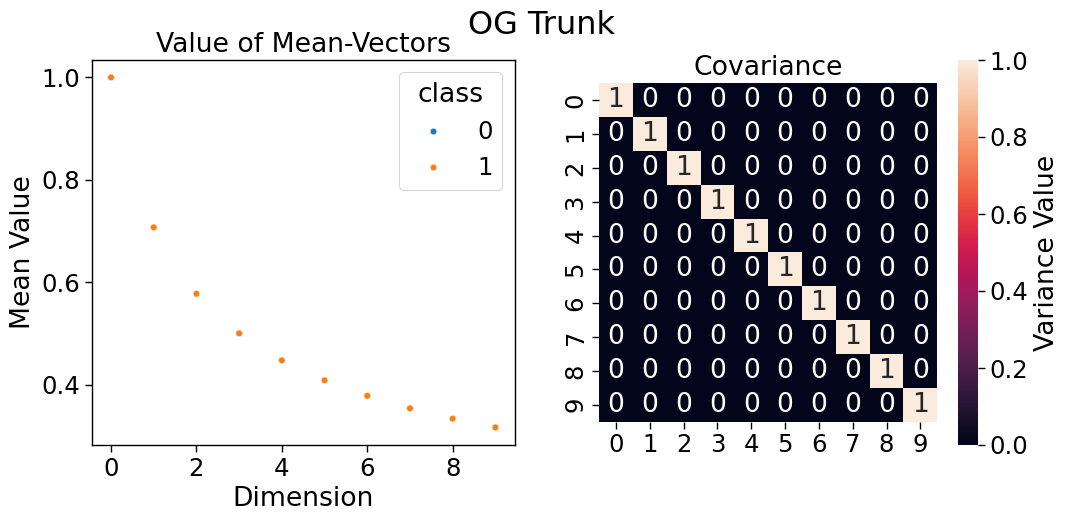

In [51]:
# X, y, means, covs = make_trunk_classification(
#     n_samples=n_samples,
#     n_dim=n_dim,
#     n_informative=5,
#     mix=0.5,
#     m_factor=-1.0,
#     return_params=True,
# )
means = mu
covs = cov

df = pd.DataFrame(means).T
df.reset_index(inplace=True)
df.columns = ["dimension", "0", "1"]
df = pd.melt(df, id_vars=("dimension",), value_name="mean", var_name="class")

sns.set_context("paper", font_scale=2.0)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = sns.scatterplot(x="dimension", y="mean", hue="class", data=df, ax=axs[0])
ax.set(xlabel="Dimension", ylabel="Mean Value", title="Value of Mean-Vectors")

ax = sns.heatmap(
    covs[0], annot=True, square=True, ax=axs[1], cbar_kws={"label": "Variance Value"}
)
ax.set_title("Covariance")
fig.suptitle("OG Trunk")
plt.show()

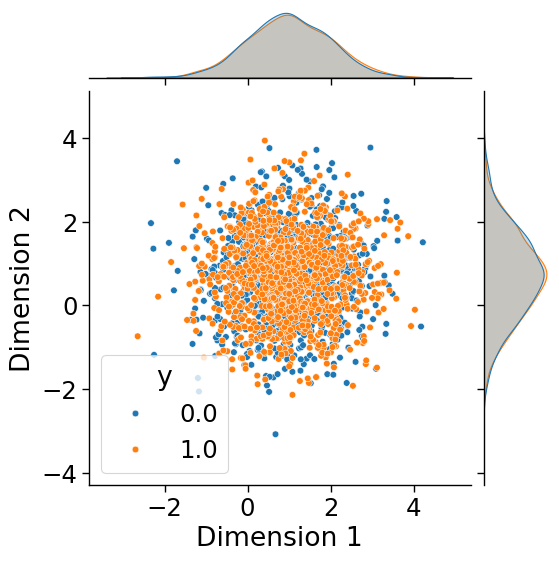

In [52]:
# Combine X and y into a DataFrame
data = pd.DataFrame({"Dimension 1": X[:, 0], "Dimension 2": X[:, 1], "y": y.ravel()})

# Create a joint plot with different colors for y == 0 and y == 1
sns.jointplot(data=data, x="Dimension 1", y="Dimension 2", hue="y", kind="scatter")
plt.show()
# # Create a joint plot
# sns.jointplot(x=X[np.argwhere(y == 1).squeeze(), 0], y=X[np.argwhere(y == 1).squeeze(), 1], kind="scatter")
# sns.jointplot(x=X[np.argwhere(y == 0).squeeze(), 0], y=X[np.argwhere(y == 0).squeeze(), 1], kind="scatter")
# # sns.jointplot(x=X[:, 0], y=X[:, 1], kind="scatter")